# Newton and Quasi-Newton Methods

In [1]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
import time

### Problem 1

In [2]:
def newton_method(df, d2f, x0, maxiter, tol):
    x_k = x0
    converged = False
    for itr in range(maxiter):
        df_xk = df(x_k)
        d2f_xk = d2f(x_k)
        z_k = np.linalg.solve(d2f_xk, df_xk)
        x_kp1 = x_k - z_k
        err = np.linalg.norm(df_xk, np.inf)
        if err < tol:
            converged = True
            break
        x_k = x_kp1
    return x_k, converged, itr+1

f = opt.rosen           # The Rosenbrock function.
df = opt.rosen_der      # The first derivative.
d2f = opt.rosen_hess    # The second derivative (Hessian).
result1 = newton_method(df, d2f, [-2, 2], 50, 1e-5)
if result1[1]:
    print("The method converged in ", result1[2], "iterations")
    print("x=", result1[0])
else:
    print("The method did not converge")
print("\nResults from opt.fmin_bfgs:")
result2 = opt.fmin_bfgs(f=f, x0=[-2,2], fprime=df)
print(result2)
print(result2)

The method converged in  6 iterations
x= [1. 1.]

Results from opt.fmin_bfgs:
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 35
         Function evaluations: 42
         Gradient evaluations: 42
[1.00000021 1.00000045]
[1.00000021 1.00000045]


### Problem 2

In [3]:
def BFGS(df, x0, maxiter, tol):
    x_k = x0
    invA_k = np.eye(len(x0))
    converged = False
    terminated = False
    for itr in range(maxiter):
        df_xk = df(x_k)
        x_kp1 = x_k - (invA_k @ df_xk.T)
        s_k = x_kp1 - x_k
        df_xkp1 = df(x_kp1)
        y_k = df_xkp1.T - df_xk.T
        den2 = s_k.T @ y_k
        den1 = (den2) ** 2
        
        # Condition for early termination
        if den1 < 1e-50:
            terminated = True
            break
        num1 = (den2 + y_k.T @ invA_k @ y_k) * np.outer(s_k, s_k)
        num2 = invA_k @ np.outer(y_k, s_k) + np.outer(s_k, y_k) @ invA_k
        invA_kp1 = invA_k + num1/den1 - num2/den2
        
        err = np.linalg.norm(df_xk, np.inf)
        if err < tol:
            converged = True
            break
        x_k = x_kp1
        invA_k = invA_kp1
    return x_k, converged, terminated, itr+1

result = BFGS(df, [-2, 2], 200, 1e-5)
if result[2]:
    print("Terminated in",  result[3], "iterations to avoid dividing by 0")
if result[1]:
    print("The method converged in ", result[3], "iterations")
    print("x=", result1[0])
else:
    print("The method did not converge")

The method converged in  149 iterations
x= [1. 1.]


### Problem 3

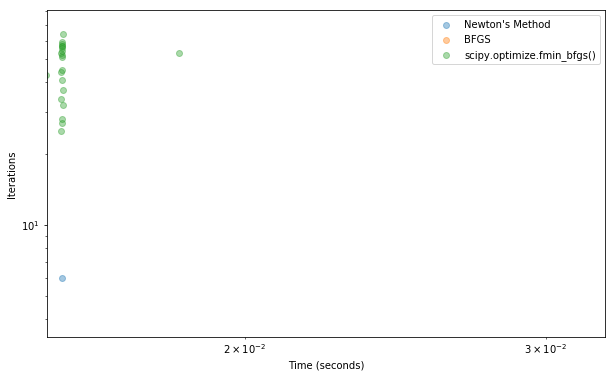

In [4]:
# Define the function
def cmprsn_plot(N):
    n_iters = np.zeros(N)
    n_time = np.zeros(N, dtype=np.float64)
    bfgs_iters = np.zeros(N)
    bfgs_time = np.zeros(N, dtype=np.float64)
    scipy_iters = np.zeros(N)
    scipy_time = np.zeros(N, dtype=np.float64)
    
    for i in range(N):
        # Saple initial random guess
        x0 = np.random.uniform(-3, 3, size=2)
        # time for the newton's method
        n_start = time.time()
        n_iters[i] = newton_method(df, d2f, x0, 200, 1e-5)[2]
        n_time[i] = time.time() - n_start
        
        # time for the BFGS method
        bfgs_start = time.time()
        bfgs_iters[i] = BFGS(df, x0, 200, 1e-5)[2]
        bfgs_time[i] = time.time() - bfgs_start
        
        scipy_start = time.time()
        scipy_iters[i] = len(opt.fmin_bfgs(f=f, x0=x0, fprime=df, disp=False, retall=True)[1])
        scipy_time[i] = time.time() - scipy_start
    
    plt.figure(figsize=(10, 6))
    plt.loglog()
    plt.scatter(n_time, n_iters, alpha=0.4, label="Newton\'s Method")
    plt.scatter(bfgs_time, bfgs_iters, alpha=0.4, label="BFGS")
    plt.scatter(scipy_time, scipy_iters, alpha=0.4, label="scipy.optimize.fmin_bfgs()")
    #plt.loglog()
    plt.xlabel('Time (seconds)')
    plt.ylabel('Iterations')
    plt.legend()
    plt.show()

# Call the function
cmprsn_plot(100)

### Problem 4

In [5]:
def gauss_newton(phi, r, J, x0, maxiter=10000, tol=1e-6):
    x_k = x0
    converged = False
    for iter in range (maxiter):
        r_xk = r(x_k)
        J_xk = J(x_k)
        Df_xk = J_xk.T @ r_xk
        D2f_xk = J_xk.T @ J_xk
        z_k = np.linalg.solve(D2f_xk, Df_xk)
        x_kp1 = x_k - z_k
        err = np.linalg.norm(x_kp1 - x_k, np.inf)
        if err < tol:
            converged = True
            break
        x_k = x_kp1
    niters = iter+1
    return x_k, converged, niters
# Generate random data
T = np.arange(10)
y = 3*np.sin(0.5*T)+ 0.5*np.random.randn(10)
# Define model function
model = lambda x, t: x[0]*np.sin(x[1]*t)
residual = lambda x: model(x, T) - y
# Define jacobian
jac = lambda x: np.column_stack((np.sin(x[1]*T), x[0]*T*np.cos(x[1]*T)))
# Call the function with x0
x0 = np.array([2.5,.6])
result = gauss_newton(model, residual, jac, x0, maxiter=10, tol=1e-3)

# call scipy.optimize.leastsq()
minx = opt.leastsq(func=residual, x0=np.array([2.5,.6]), Dfun=jac)
print(result)
print(minx)

(array([2.92846451, 0.50090314]), True, 4)
(array([2.9282714 , 0.50108044]), 1)


### Problem 5

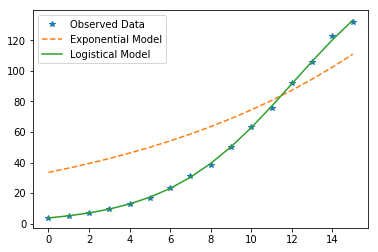

In [6]:
# Load data
population = np.load('population.npy')
# Define function
T = population[:, 0]
y = population[:, 1]

# model with the exponential function
model1 = lambda x, t: x[0]*np.exp(x[1]*(t+x[2]))
residual1 = lambda x: model1(x, T) - y
jac1 = lambda x: np.column_stack((np.exp(x[1]*(T+x[2])), x[0]*(T+x[2])*np.exp(x[1]*(T+x[2])), x[0]*x[1]*np.exp(x[1]*(T+x[2]))))
x0 = np.array([1.5, 0.4, 2.5])
x1, conv1, niters1 = gauss_newton(model1, residual1, jac1, x0, maxiter=10, tol=1e-5)

# model with the logistic function
model2 = lambda x, t: x[0]/(1+np.exp(-x[1]*(t+x[2])))
residual2 = lambda x: model2(x, T) - y
jac2 = lambda x: np.column_stack((1/(1+np.exp(-x[1]*(T+x[2]))), \
                                  x[0]*(T+x[2])*np.exp(-x[1]*(T+x[2]))/((1+np.exp(-x[1]*(T+x[2])))**2), \
                                  x[0]*x[1]*np.exp(-x[1]*(T+x[2]))/((1+np.exp(-x[1]*(T+x[2])))**2)))
x0 = np.array([150, 0.4, -15])
x2, conv2, niters2 = gauss_newton(model2, residual2, jac2, x0, maxiter=10, tol=1e-3)
plt.plot(T, y, '*', label="Observed Data")
plt.plot(T, model1(x1, T), '--', label="Exponential Model")
plt.plot(T, model2(x2, T), label="Logistical Model")
plt.legend()
plt.show()